# DRC Roads - Classification

In this notebook we focus on classification of pixels in a scene as forest or non-forest. This scene is from a region in the Dominican Republic of Congo where roads have been built into the forest. Searching for and downloading the scenes is covered in the [drc_roads_download](drc_roads_download.ipynb) notebook.

This notebook demonstrates the following:
- using code (strip downloader) from another notebook
- texture analysis of a scene
- classification of pixels into forest / non-forest
 - Need to account for clouds
 - start with k-means (unsupervised) then try random forests

Keywords: 

In [1]:
import os

import ipynb.fs
import numpy as np
import pandas as pd
from planet import api
import rasterio

In [40]:
from skimage import feature, filters
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier

## Download Scene

use ipynb to import StripDownloader from drc-roads-download notebook
use StripDownloader to download strip 73199.

In [3]:
# import StripDownloader from drc_roads_download notebook
from .defs.drc_roads_download import StripDownloader

In [4]:
# create planet api client
planet_api_key = os.environ['PL_API_KEY']

# quick check that key is defined
assert planet_api_key, "PL_API_KEY not defined."

client = api.ClientV1(api_key=planet_api_key)

In [9]:
# load scenes database. Saved in drc_roads_download notebook
overlapping_scenes_filename = os.path.join('pre-data', 'overlapping-scenes')
overlapping_scenes = pd.read_pickle(overlapping_scenes_filename)

In [10]:
# filter to only scenes in desired strip
strip_id = '739199'
strip_scenes = overlapping_scenes[overlapping_scenes['strip_id'] == strip_id]

In [11]:
aoi_geojson_filename = os.path.join('pre-data', 'aoi.geojson')

In [12]:
asset_type = 'analytic'

In [13]:
strip_downloader = StripDownloader(overlapping_scenes, aoi_geojson_filename, client)
strip_downloader.run(asset_type, overwrite=False, verbose=True)

9 strips
found data/943459_mosaic.tif
found data/904538_mosaic.tif
found data/915538_mosaic.tif
found data/883193_mosaic.tif
found data/879726_mosaic.tif
found data/863467_mosaic.tif
found data/758681_mosaic.tif
found data/741529_mosaic.tif
found data/739199_mosaic.tif
Nothing to download


In [14]:
image_file = strip_downloader.get_filename(strip_id)
image_file

'data/739199_mosaic.tif'

## Visualize Scene

In [15]:
# load local visual module
import visual

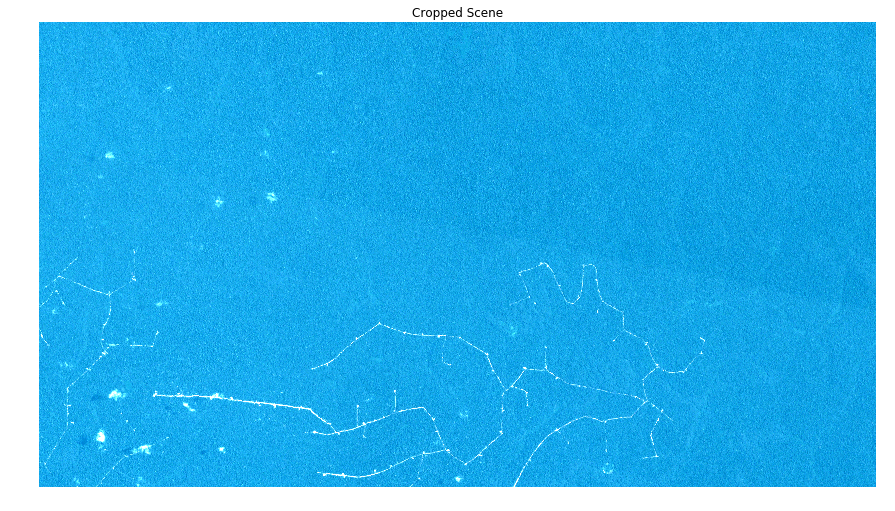

In [16]:
def load_4band(filename):
    with rasterio.open(filename, 'r') as src:
        # orthotile band ordering: blue, green, red, nir
        b, g, r, n = src.read() 

        mask = b == 0 # 0 is NoData

    return [np.ma.array(band, mask=mask) for band in [b, g, r, n]]
    
def visualize_4band(filename, title='Cropped Scene'):
    bgrn_bands = load_4band(filename)

    rgb_bands = [bgrn_bands[i] for i in [2, 1, 0]]
    visual.plot_image(rgb_bands, title=title, figsize=(15, 15))

visualize_4band(image_file)

## Analyze Strip Scene

To detect roads vs forests we will use texture analysis. For simplicity, we will focus on the green band, which is pretty responsive to forest/non-forest.

In [86]:
def load_green_band(filename):
    bgrn_bands = load_4band(filename)
    green_band = bgrn_bands[1]
    return green_band

def visualize_single_band(band, title='Single-band image'):
    visual.plot_image(3 * [band], title=title, figsize=(15, 15))
    
green_band = load_green_band(image_file)
visualize_single_band(green_band, title='Green Band')

In [18]:
def normalize(band):
    return (band-band.min())/(band.max()-band.min())

def scale(band):
    return normalize(band) * np.iinfo(band.dtype).max

In [19]:
green_band_normalized = scale(green_band.data)

In [20]:
edges1 = feature.canny(green_band_normalized, sigma=2)
visualize_single_band(np.ma.array(edges1, mask=green_band.mask), title='Green Band Edges')

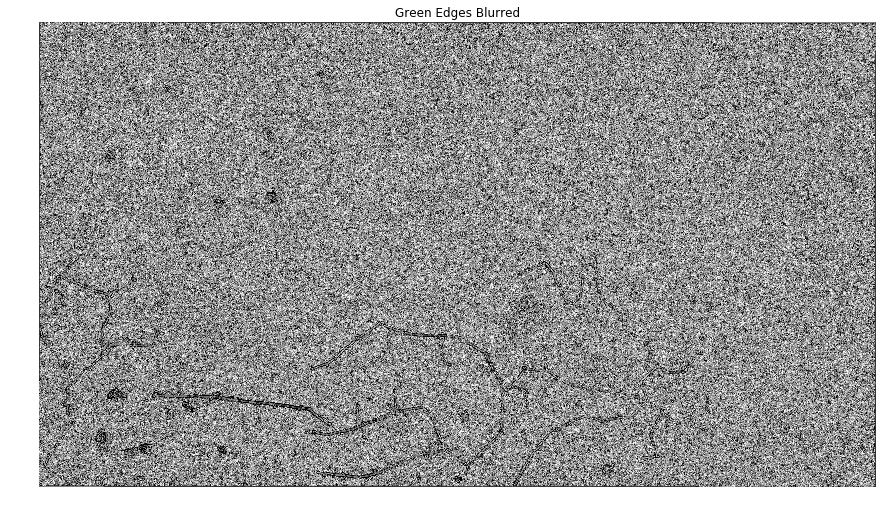

In [21]:
blurred = filters.gaussian(edges1, sigma=2)
visualize_single_band(np.ma.array(blurred, mask=green_band.mask), title='Green Edges Blurred')

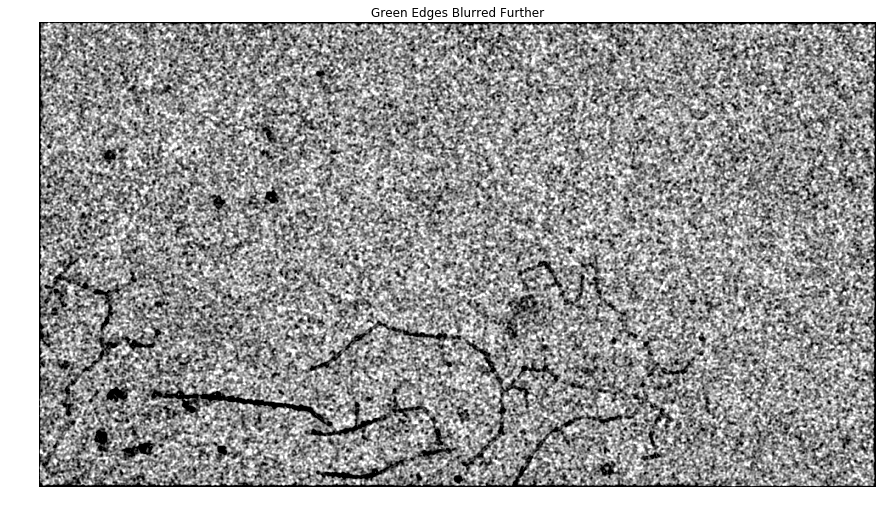

In [22]:
blurred2 = filters.gaussian(edges1, sigma=6)
visualize_single_band(np.ma.array(blurred2, mask=green_band.mask),
                      title='Green Edges Blurred Further')

## Classify Pixels - Unsupervised (KMeans)

To classify pixels, we will combine their Red, Green, Blue, and NIR spectral values with their texture (blurred edges) information into one vector, then we will feed that vector into a K-means classifier.

In [23]:
# need to scale bands for KMeans (isotropic calculation)
scaled_bands = [normalize(b) for b in load_4band(image_file)]
b_bands = [np.ma.array(normalize(b), mask=green_band.mask) for b in (blurred, blurred2)]
feature_bands = np.dstack(scaled_bands + b_bands)

In [24]:
n_samples = feature_bands.shape[0] * feature_bands.shape[1]
n_samples

20024664

Because there are over 10 thousand samples, we will use scikit-learn's [mini batch k means](https://scikit-learn.org/stable/modules/clustering.html#mini-batch-k-means) function to reduce computation.

In [25]:
mbk = MiniBatchKMeans(n_clusters=2)

In [66]:
def bands_to_X(bands):
    n_samples = bands.shape[0] * bands.shape[1]
    n_features = feature_bands.shape[-1]
    new_shape = (n_samples, n_features)
    return bands.reshape(new_shape)

def X_to_bands(X, band_shape):
    n_samples, n_features = X.shape
    assert (band_shape[0] * band_shape[1]) == n_samples
    new_shape = (band_shape[0], band_shape[1], n_features)
    return X.reshape(new_shape)

In [67]:
X = bands_to_X(feature_bands)

In [68]:
with Timer():
    mbk.fit(X)

50 seconds


In [69]:
with Timer():
    y_pred = mbk.predict(X)

52 seconds


In [79]:
def y_to_band(y, band_shape):
    assert len(y.shape) == 1
    n_samples, = y.shape
    assert (band_shape[0] * band_shape[1]) == n_samples
    new_shape = (band_shape[0], band_shape[1], )  
    return y.reshape(new_shape)

In [80]:
y_band = y_to_band(y_pred, feature_bands.shape[:2])

In [81]:
# separate the cluster numbers into rgb bands
y_bands = [np.ma.array(y_band == n, mask=green_band.mask) for n in [0,1,2]]

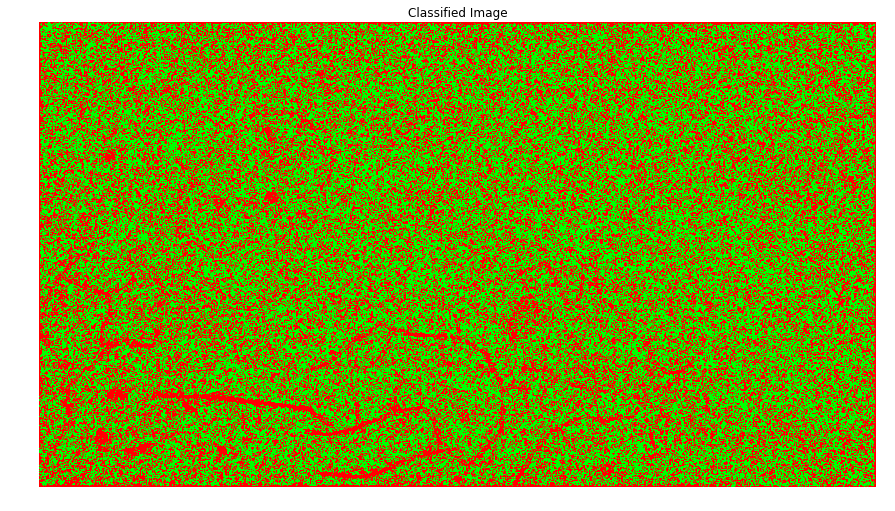

In [82]:
visual.plot_image(y_bands, title='Classified Image', figsize=(15, 15))

The roads do show up in this classified image, although there is also a lot of noise.

## Classify Pixels - Supervised (Random Forests)

In this section we use training data prepared in an external notebook.

In [96]:
# load training data
training_data_file = os.path.join('pre-data', 'classification_training.npz')
npzfile = np.load(training_data_file)
X_training = npzfile['X']
y_training = npzfile['y']

In [97]:
# Let's create a timer to report time if we wish
import time

# inspired by https://preshing.com/20110924/timing-your-code-using-pythons-with-statement/
class Timer: 
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = int(self.end - self.start)
        print('{} seconds'.format(self.interval))

In [61]:
with Timer():
    clf = RandomForestClassifier()

0 seconds


In [98]:
with Timer():
    clf.fit(X_training, y_training)

0 seconds


In [104]:
b_bands = [np.ma.array(normalize(b), mask=green_band.mask) for b in (blurred, blurred2)]
feature_bands_rf = np.dstack(load_4band(image_file) + b_bands)
X_rf = bands_to_X(feature_bands_rf)
X_rf.shape

(20024664, 6)

In [105]:
with Timer():
    y_pred_rf = clf.predict(X_rf)

5 seconds


In [106]:
y_band_rf = y_to_band(y_pred_rf, feature_bands_rf.shape[:2])

In [107]:
# separate the cluster numbers into rgb bands
y_bands_rf = [np.ma.array(y_band_rf == n, mask=green_band.mask) for n in [0,1,2]]

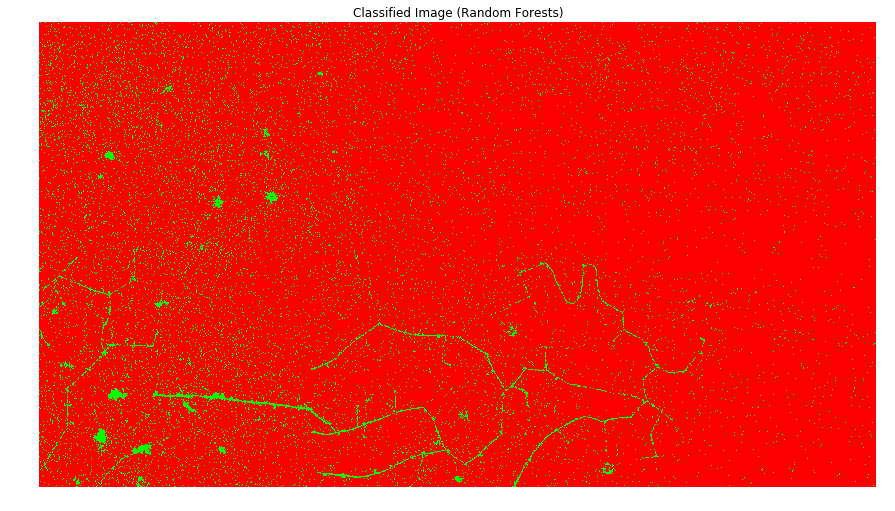

In [108]:
visual.plot_image(y_bands_rf, title='Classified Image (Random Forests)', figsize=(15, 15))

That looks MUCH BETTER! Yay!